# CVE Patch Identification



GitHub Link: [openshift.io:4228](https://github.com/openshiftio/openshift.io/issues/4228)
Description:

Maven support in CVEjob is lacking behind NPM and Python support. The reason for that is the complexity of Maven ecosystem, namely multi-module projects which publish multiple artifacts for each release and the naming schema (gid:aid::) which is very different from other “standard” language ecosystems.

Sometimes the only way how to reliably map CVE for complex Maven project is to find the patch which fixes the vulnerability. We want to research whether it would be possible, at least to some degree, identify commits in Git which likely fix some security issue (those that have “CVE-xxxx-xxxx” in the description, or other keywords).

Input:

    - git repository and commit range - we don’t need to check all commits in the repository, only commits between 2 releases (we know the fix is there somewhere)
    - CVE record from NVD

Note this is just a research, we don’t expect to have anything production-ready at the end.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CVE-Patch-Identification" data-toc-modified-id="CVE-Patch-Identification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CVE Patch Identification</a></span></li><li><span><a href="#global" data-toc-modified-id="global-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>global</a></span></li><li><span><a href="#ops" data-toc-modified-id="ops-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ops</a></span><ul class="toc-item"><li><span><a href="#Data-Gathering" data-toc-modified-id="Data-Gathering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Gathering</a></span><ul class="toc-item"><li><span><a href="#Sample-of-Topic-data" data-toc-modified-id="Sample-of-Topic-data-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Sample of Topic data</a></span></li><li><span><a href="#Example-of-commit-fixing-a-CVE" data-toc-modified-id="Example-of-commit-fixing-a-CVE-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Example of commit fixing a CVE</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Jenks-Natural-Breaks" data-toc-modified-id="Jenks-Natural-Breaks-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Jenks Natural Breaks</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>TF-IDF</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Spacy" data-toc-modified-id="Spacy-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Spacy</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-3.2.3.1"><span class="toc-item-num">3.2.3.1&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Gensim" data-toc-modified-id="Gensim-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Gensim</a></span><ul class="toc-item"><li><span><a href="#Topic-Classification-Approach" data-toc-modified-id="Topic-Classification-Approach-3.2.4.1"><span class="toc-item-num">3.2.4.1&nbsp;&nbsp;</span>Topic Classification Approach</a></span></li><li><span><a href="#Description-similarity" data-toc-modified-id="Description-similarity-3.2.4.2"><span class="toc-item-num">3.2.4.2&nbsp;&nbsp;</span>Description similarity</a></span></li></ul></li></ul></li></ul></li></ul></div>

# global

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import re
import requests
import sys

import json
import yaml

from io import StringIO
from contextlib import redirect_stdout

import ipywidgets as widgets

import nltk

import numpy as np
import pandas as pd

import spacy

from spacy.attrs import ORTH, LEMMA, ENT_TYPE, ENT_IOB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from jenkspy import jenks_breaks

from nltk.corpus import stopwords
from collections import namedtuple, Counter, OrderedDict

from IPython.display import Javascript, clear_output
from prettyprinter import pprint

import gensim
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, DEFAULT_FILTERS
from gensim.models.doc2vec import Doc2Vec, Doc2VecKeyedVectors, Doc2VecVocab
from gensim.models.word2vec import Word2Vec

import nvdlib

from nvdlib.manager import FeedManager
from nvdlib import query_selectors as q
from nvdlib import utils

In [5]:
# download model with vectors (if applicable)
spacy.cli.download('en_core_web_md')


    Linking successful
    /home/macermak/.local/lib/python3.6/site-packages/en_core_web_md -->
    /home/macermak/.local/lib/python3.6/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [6]:
# set up parser
nlp = spacy.load('en_core_web_md')  # load model with vectors

# custom models
#  model trained on 20k cves from cvedetails.com
# nlp = spacy.load('data/spacy/w2v_cvedetails_20k/')
# model trained on 100k cves, full collection
# nlp = spacy.load('data/spacy/w2v_cve_collection_100k/')

In [8]:
LEMMA_BLACKLIST = {
    'number', 'numb', 'version', 'release'
}

CVE_PATTERN = r"C[VW]E(-\d+)?(-\d+)?"
CVE_TOKEN = u'>CVE<'

VERSION_PATTERN = r"[v]?(?P<major>\d+)[.](?P<minor>\d+|((\d+)|[xX]{1,}))([.](?P<patch>\d+|((\d+)|[xX]{1,})))?(?P<release>[-]?[A-Za-z]+)?"
VERSION_TOKEN = u'>VERSION<'

NUMBER_TOKEN = u'>NUMBER<'
CVE_PATTERN = r"C[VW]E(-\d+)?(-\d+)?"
CVE_TOKEN = u'CVE'

VERSION_PATTERN = r"[v]?(?P<major>\d+)[.](?P<minor>\d+|((\d+)|[xX]{1,}))([.](?P<patch>\d+|((\d+)|[xX]{1,})))?(?P<release>[-]?[A-Za-z]+)?"
VERSION_TOKEN = u'>VERSION<'

# add special cases to the tokenizer
cve_case = [{ORTH: CVE_TOKEN, LEMMA: 'cve'}]
version_case = [{ORTH: VERSION_TOKEN, LEMMA: 'version'}]

nlp.tokenizer.add_special_case(CVE_TOKEN, cve_case)
nlp.tokenizer.add_special_case(VERSION_TOKEN, version_case)
nlp.tokenizer.add_special_case('<', [{ORTH: 'lower than', LEMMA: 'low'}])
nlp.tokenizer.add_special_case('>', [{ORTH: 'greater than', LEMMA: 'high'}])

TOPICS = ['DoS', 'Code Execution', 'Overflow', 'Memory Corruption', 'Sql Injection', 'XSS',
          'Directory Traversal', 'Http Response Splitting', 'Bypass something', 'Gain Information',
          'Gain Privileges', 'CSRF', 'File Inclusion']

API_BASE_URL = "https://api.github.com/repos/{owner}/{repo}"

API_COMMIT_URL = API_BASE_URL + "/commits?sha={sha}"
API_TAG_URL = API_BASE_URL + "/tags"

with open('secrets', 'r') as f:
    TOKEN = f.read().strip()
    HEADERS = {'Authorization': f"token {TOKEN}"}

In [9]:
def get_tags(owner: str, repo: str):
    
    def _get_tags(url, tags = []):
        
        if url is None:
            return tags
        
        response = requests.get(url, headers=HEADERS)
    
        if response.status_code != 200:
            raise ResponseStatusError(
                f"Response status code returned: {response.status_code}",
                status_code=response.status_code
            )
        
        tags.extend(response.json())
        next_page = response.links.get('next', {}).get('url', None)
        
        return _get_tags(next_page, tags)

    url = API_TAG_URL.format(owner=owner, repo=repo)
    
    return _get_tags(url)

def tag_to_hash(tag): return tag['commit']['sha']

VERSION_PATTERN = r"[v]?(?P<major>\d+)[.](?P<minor>\d+|((\d+)|[xX]{1,}))([.](?P<patch>\d+|((\d+)|[xX]{1,})))?(?P<release>[-]?[A-Za-z]+)?"

class ResponseStatusError(Exception):
    
    def __init__(self, *args, **kwargs):
        self.status_code = kwargs.pop('status_code', None)
        
        super().__init__(self.status_code, *args, **kwargs)
        
    
def get_commits(owner: str = None,
                repo: str = None,
                newest: str = '',
                oldest: str = '',
                tags: list = [],
                limit: int = 500) -> list:
    """Return commits between (and excluding given commits).
    
    NOTE: Commits are sorted from newest to oldest.
    """
    if any([newest, oldest]) and not tags:
        raise ValueError("If `oldest` or `newest` is specified, `tags` must be provided.")
    
    hash_newest = newest
    hash_oldest = oldest
    
    if any([bool(re.fullmatch(VERSION_PATTERN, c)) for c in [newest, oldest]]):
        for t in tags:
            if newest and re.fullmatch(t['name'], newest):
                hash_newest = tag_to_hash(t)
            elif oldest and re.fullmatch(t['name'], oldest):
                hash_oldest = tag_to_hash(t)
    
    def _get_commits(url, commits = []):
        
        if url is None:
            return commits
        
        if len(commits) >= limit:
            return commits[:limit]
    
        response = requests.get(url, headers=HEADERS)
    
        if response.status_code != 200:
            raise ResponseStatusError(
                f"Response status code returned: {response.status_code}",
                status_code=response.status_code
            )

        commits.extend(response.json())

        if hash_oldest:
            for i, commit_dict in enumerate(commits):
                if commit_dict['sha'].startswith(hash_oldest):
                    commits = commits[:i+1]
                    
                    return commits
                
        next_page = response.links.get('next', {}).get('url', None)
        
        return _get_commits(next_page, commits)

    url = API_COMMIT_URL.format(owner=owner, repo=repo, sha=hash_newest)
    
    return _get_commits(url)

Commit = namedtuple('Commit', [
    'url', 'sha', 'message'
])

def parse_commit(commit: dict) -> Commit:
    if not isinstance(commit, dict):
        raise TypeError(f"dict expected, got {type(commit)}")
        
    url: str = commit['url']
    sha: str = commit['sha']
        
    message: str = commit['commit']['message']
    
    return Commit(
        url=url,
        sha=sha,
        message=message,
    )

# ---

def clean_text(text: str):
    text = text.lower()
    
    text = re.sub(CVE_PATTERN, CVE_TOKEN, text, flags=re.IGNORECASE)
    text = re.sub(VERSION_PATTERN, VERSION_TOKEN, text, flags=re.IGNORECASE)
    # don't care about numbers
    text = re.sub(r"[0xb]*(\d+)", NUMBER_TOKEN, text)
    
    return text

def entitizer(doc):
    for i, token in enumerate(doc):
        if token.orth_ in [CVE_TOKEN, VERSION_TOKEN, NUMBER_TOKEN]:
            span = spacy.tokens.Span(doc, i, i+1, label=doc.vocab.strings[u'CARDINAL'])
            doc.ents = list(doc.ents) + [span]
    
    return doc

def display_entities(doc):
    spacy.displacy.render(doc, style='ent', options={'compact': True}, jupyter=True)

# vectorizer = CountVectorizer(tokenizer=lambda doc: [t.lemma_ for t in nlp.tokenizer(doc)])
def include_token(token):
    ret = True
    
    if not token.is_alpha or len(token.lemma_) < 1:
        ret = False
    elif token.lemma_ in nlp.Defaults.stop_words:
        ret = False
    elif token.lemma_ in LEMMA_BLACKLIST:
        ret = False
    
    return ret

# ---

# check for cve in commits
def contains_cve(commit):
    for token in commit:
        if re.fullmatch(CVE_PATTERN, token.lemma_, flags=re.IGNORECASE):
            return True
    
    return False

def get_commit_score_per_topic(commit, lookup_table):
    word_set = set(commit)
    commit_vec = np.empty((len(word_set), len(lookup_table))) 
   
    for jdx, token in enumerate(word_set):
        token_vec = np.zeros((len(lookup_table), ))
        try:
#             token_vec = lookup_table[token.lemma_.lower()]
            for topic_idx, topic in enumerate(lookup_table):
                token_vec[topic_idx], = topic[token.lemma_.lower()].values
        except KeyError:
            pass
        
        commit_vec[jdx] = token_vec
    
    return commit_vec
        
def get_commit_score(commit, lookup_table, u=None):
    commit_vec = get_commit_score_per_topic(commit, lookup_table)
    if u:
        commit_vec = commit_vec[np.argsort(commit_vec.sum(axis=1))[::-1][:int(u)]]
    
    return commit_vec.sum(axis=0)

def get_interval(intervals, num):
    i = 0
    for i, (low, high) in enumerate(intervals):
        if low <= num < high:
            return i
    
    return i

def unravel2d(index, arr):
    flat_idx = 0
    
    for idx, sub_arr in enumerate(arr):
        for jdx, element in enumerate(sub_arr):
            
            if flat_idx == index:
                return (idx, jdx), element
            
            flat_idx += 1

# ops

## Data Gathering

In [10]:
topic_df = pd.read_csv('data/cvedetails.csv')

In [11]:
# duplicate row into every relevant topic

topic_data = []
for idx, row in topic_df.iterrows():
    
    # split by vulnerabilities
    vulnerabilities = preprocess_string(row.vulnerabilities, filters=DEFAULT_FILTERS[:-1])
    for v in vulnerabilities:
        used_topics = []
        
        # find relevant topics
        for idx, topic in enumerate(TOPICS):
            if re.search(v, topic, flags=re.IGNORECASE) and not idx in used_topics:
                row_ = row.copy()
                row_['topic'] = topic
                
                topic_data.append(row_)
                used_topics.append(idx)

In [12]:
topic_df = pd.DataFrame(topic_data)

In [13]:
topic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67234 entries, 0 to 29330
Data columns (total 15 columns):
cve_id             67234 non-null object
cwe_id             58154 non-null float64
vulnerabilities    67234 non-null object
publish_date       67234 non-null object
update_date        67234 non-null object
score              67234 non-null float64
access_level       67234 non-null object
access             67234 non-null object
complexity         67234 non-null object
auth               67234 non-null object
confidentiality    67234 non-null object
integrity          67234 non-null object
availability       67234 non-null object
summary            67234 non-null object
topic              67234 non-null object
dtypes: float64(2), object(13)
memory usage: 8.2+ MB


In [14]:
topic_df = topic_df.set_index(['topic', 'cve_id'])

index = topic_df.index
v_idx = index.get_level_values(level=0).unique()

### Sample of Topic data

In [15]:
topic_df.sample(10)

cwe_id           vulnerabilities  \
topic                   cve_id                                               
Gain Information        CVE-2017-8118      200.0                     +Info   
                        CVE-2018-11338       NaN                     +Info   
Directory Traversal     CVE-2007-6290       22.0                Dir. Trav.   
DoS                     CVE-2017-15769     119.0              DoS Overflow   
Bypass something        CVE-2016-3834      200.0              Bypass +Info   
Code Execution          CVE-2015-0029      399.0  DoS Exec Code Mem. Corr.   
Gain Information        CVE-2017-13204     200.0                     +Info   
Overflow                CVE-2018-0304      119.0    DoS Exec Code Overflow   
Http Response Splitting CVE-2006-6965        NaN           XSS Http R.Spl.   
XSS                     CVE-2018-1000160    79.0                       XSS   

                                         publish_date update_date  score  \
topic                   cve_id                                             
Gain Information        CVE-2017-8118      2017-11-22  2017-12-08    2.1   
                        CVE-2018-11338     2018-07-31  2018-07-31    0.0   
Directory Traversal     CVE-2007-6290      2007-12-10  2017-09-28    5.0   
DoS                     CVE-2017-15769     2017-10-22  2017-10-24    6.8   
Bypass something        CVE-2016-3834      2016-08-05  2016-11-28    4.3   
Code Execution          CVE-2015-0029      2015-02-10  2015-09-01    9.3   
Gain Information        CVE-2017-13204     2018-01-12  2018-01-25    8.5   
Overflow                CVE-2018-0304      2018-06-20  2018-08-13   10.0   
Http Response Splitting CVE-2006-6965      2007-01-29  2017-07-28    4.3   
XSS                     CVE-2018-1000160   2018-04-18  2018-05-21    4.3   

                                         access_level  access complexity  \
topic                   cve_id                                             
Gain Information        CVE-2017-8118            None   Local        Low   
                        CVE-2018-11338           None     ???        ???   
Directory Traversal     CVE-2007-6290            None  Remote        Low   
DoS                     CVE-2017-15769           None  Remote     Medium   
Bypass something        CVE-2016-3834            None  Remote     Medium   
Code Execution          CVE-2015-0029            None  Remote     Medium   
Gain Information        CVE-2017-13204           None  Remote        Low   
Overflow                CVE-2018-0304            None  Remote        Low   
Http Response Splitting CVE-2006-6965            None  Remote     Medium   
XSS                     CVE-2018-1000160         None  Remote     Medium   

                                                  auth confidentiality  \
topic                   cve_id                                           
Gain Information        CVE-2017-8118     Not required         Partial   
                        CVE-2018-11338             ???             ???   
Directory Traversal     CVE-2007-6290     Not required         Partial   
DoS                     CVE-2017-15769    Not required         Partial   
Bypass something        CVE-2016-3834     Not required         Partial   
Code Execution          CVE-2015-0029     Not required        Complete   
Gain Information        CVE-2017-13204    Not required         Partial   
Overflow                CVE-2018-0304     Not required        Complete   
Http Response Splitting CVE-2006-6965     Not required            None   
XSS                     CVE-2018-1000160  Not required            None   

                                         integrity availability  \
topic                   cve_id                                    
Gain Information        CVE-2017-8118         None         None   
                        CVE-2018-11338         ???          ???   
Directory Traversal     CVE-2007-6290         None         None   
DoS                     CVE-2017-15769     Partial     

In [16]:
vectorizer = TfidfVectorizer(tokenizer=lambda doc: [
    t.lemma_ for t in nlp.tokenizer(doc) if include_token(t)
])

topic_data = list()

for idx in v_idx:
    # concatenate all the data for given topic
    text = [clean_text(doc) for doc in topic_df.loc[idx].summary.values]
    topic_data.append("\n".join(text))

In [17]:
tf_idf = vectorizer.fit_transform(topic_data)

/usr/lib64/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [18]:
from IPython.display import display

df = pd.DataFrame(data=tf_idf.toarray(), columns=vectorizer.get_feature_names())
# df.sort_values(by=list(df.index), axis=1, ascending=False)

topic_frames = list()

for i, topic in df.iterrows():
    topic.sort_values(ascending=False, inplace=True)
    topic_frames.append(topic.to_frame(name=v_idx[i]).transpose())

---

In [19]:
CVEDB_PATH = f"./cvedb/database"

In [20]:
database = dict()
required_nvd_feeds = set()

for eco in os.listdir(CVEDB_PATH):
    years_in_db = os.listdir(os.path.join(CVEDB_PATH, eco))
    required_nvd_feeds.update(years_in_db)
    
    for year in years_in_db:
        walk_path = os.path.join(CVEDB_PATH, eco, year)

        for root, walkdir, walkfile in os.walk(walk_path):
            for file in walkfile:
                if file.endswith('.yaml'):
                    with open(os.path.join(root, file)) as f:
                        content = yaml.load(f.read())

                    content['id'] = f"CVE-{content.pop('cve')}"
                    database[content['id']] = content

In [21]:
with FeedManager(n_workers=5) as fm:
    
    feeds = fm.fetch_feeds(required_nvd_feeds)
    collection = fm.collect(feeds)
    collection.set_name('ALL')

In [22]:
cvedb_collection = collection.find({'cve.id_': q.in_(set(database.keys()))})
cvedb_collection.set_name('CVEDB')

In [23]:
gh_cvedb_collection = cvedb_collection.find({'cve.references.data.url': q.search('github')})

In [24]:
commit_cvedb_collection = gh_cvedb_collection.find({
    'cve.references.data.url': q.search('commit'),
})

In [25]:
# widgets
owner_widget = widgets.Text(
    description="Owner: ",
    placeholder="<owner>",
    value='anymail'
)
repo_widget = widgets.Text(
    description="Repository: ",
    placeholder="<repository>",
    value='django-anymail'
)

version_lower = widgets.Text(
    description="[OPT] Oldest: ",
    placeholder="<version> [optional]",
    value='1.2'
)

version_higher = widgets.Text(
    description="[OPT] Newest: ",
    placeholder="<version> [optional]",
    value='2.0'
)

gh_box = widgets.HBox([owner_widget, repo_widget])
version_box = widgets.HBox([version_lower, version_higher])


search_button = widgets.Button(
    description="Find",
    button_style='',
    tooltip="Find commits for given repository.",
    layout=widgets.Layout(width='150px', height='60px')
)

search_box = widgets.VBox([gh_box, version_box])

In [26]:
cve_browser_button_next = widgets.Button(
    description="Next",
    button_style='',
    tooltip="Get next CVE",
    layout=widgets.Layout(width='300px')
)

cve_browser_button_previous = widgets.Button(
    description="Previous",
    button_style='',
    tooltip="Get previous CVE",
    layout=widgets.Layout(width='300px')
)

cve_browser_button_box = widgets.HBox(
    [cve_browser_button_previous, cve_browser_button_next],
    layout=widgets.Layout(
        width='100%',
        justify_content='center'
    )
)

cve_browser_area = widgets.Textarea(
    placeholder="<CVE>",
    disabled=True,
    layout=widgets.Layout(
#         overflow_x='scroll',
#         overflow_y='scroll',
        width='100%',
        height='500px',
        display='flex',
        flex_flow='row',
        align_self='flex-end'
    )
)

In [27]:
cursor = commit_cvedb_collection.cursor()

In [28]:
def next_cve(collection):
    global cursor
    
    try:
        cve = cursor.next().cve
    except StopIteration:
        cursor = collection.cursor()
        cve = cursor.next().cve
    
    return cve

def update_area_with_next_cve(handle):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,'
                       'IPython.notebook.get_selected_index()+2)'))
    
def update_area_with_previous_cve(handle):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+2,'
                       'IPython.notebook.get_selected_index()+3)'))

In [29]:
cve_browser_button_next.on_click(update_area_with_next_cve)
cve_browser_button_previous.on_click(update_area_with_previous_cve)

---

In [30]:
from collections import deque
CACHE_LIMIT = 5

previous_cves = deque(maxlen=CACHE_LIMIT)

In [31]:
display(cve_browser_area)
display(cve_browser_button_box)

Textarea(value='', disabled=True, layout=Layout(align_self='flex-end', display='flex', flex_flow='row', height…

In [32]:
buffer = StringIO()
with redirect_stdout(buffer):
    cve = next_cve(gh_cvedb_collection)
    cve.pretty()
    
    value = buffer.getvalue()
    previous_cves.append(value)

buffer.close()
    
cve_browser_area.value = value

In [33]:
if previous_cves and previous_cves[0] != cve_browser_area.value:
    
    cve_browser_area.value = previous_cves.popleft()

---

In [34]:
def search_and_update(handle):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,'
                       'IPython.notebook.get_selected_index()+11)'))

search_button.on_click(search_and_update)

In [35]:
display(widgets.HBox(
    [search_box, search_button],
    layout=widgets.Layout(width='100%', align_items='center', justify_content='center', display='flex')
))

In [36]:
owner = owner_widget.value
repo = repo_widget.value

v_oldest = version_lower.value
v_newest = version_higher.value

tags = []
if owner and repo:
    tags = get_tags(owner, repo)

In [37]:
tag_names = [t.get('name') for t in tags][::-1]

current_index = [0, len(tags) - 1]

if any([v_oldest, v_newest]):
    for idx, v in enumerate([v_oldest, v_newest]):
        if not v: break
        current_index[idx] = [
            idx for idx, tag in enumerate(tag_names) if re.search(v, tag)
        ][0]

In [38]:
version_range_widget = widgets.SelectionRangeSlider(
    description="Version range: ",
    options=tag_names,
    labels=tag_names,
    index=current_index,
    layout=widgets.Layout(
        width='80%',
        display='flex',
        justify_content='center'
    ),
    continuous_update=False,
)

In [39]:
def run_analysis(handle):
    display(Javascript('IPython.notebook.execute_cells_below()'))

run_analysis_button = widgets.Button(
    description="Run Analysis",
    button_style='danger',
)

run_analysis_button.on_click(run_analysis)

In [40]:
display(widgets.HBox(
    [version_range_widget],
    layout=widgets.Layout(width='100%', justify_content='center', display='flex')
))
display(widgets.HBox(
    [run_analysis_button],
    layout=widgets.Layout(width='100%', justify_content='center', display='flex')
))

---

In [41]:
commit_data = []

v_oldest, v_newest = version_range_widget.label

if owner_widget.value and repo_widget.value:
    tags = get_tags(owner, repo)
    
    commit_data = list(
        map(parse_commit, get_commits(owner=owner,
                                      repo=repo,
                                      tags=tags,
                                      oldest=v_oldest,
                                      newest=v_newest
                                     ))
    )

In [42]:
def get_commit_by_sha(sha):
    clear_output(wait=True)
    for commit in commit_data:
        if commit.sha.startswith(sha):
            return commit

def print_commit_and_update(handle):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,'
                       'IPython.notebook.get_selected_index()+2)'))

In [43]:
commit_widget = widgets.Select(
    options=list(sorted([commit.sha[:8] for commit in commit_data])),
    description="Find specific commit",
    disabled=False,
    layout=widgets.Layout(
        width='400px',
        height='150px'
    )
)

commit_widget.on_trait_change(print_commit_and_update, 'value')

/home/macermak/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  # This is added back by InteractiveShellApp.init_path()


In [44]:
display(commit_widget)

Select(description='Find specific commit', layout=Layout(height='150px', width='400px'), options=('06c7077e', …

### Example of commit fixing a CVE

In [45]:
display(pprint(get_commit_by_sha(commit_widget.value)))

Commit(
    url='https://api.github.com/repos/anymail/django-anymail/commits/'
        '06c7077e37e2371eefcb6a3146fc0cc949a256ac',
    sha='06c7077e37e2371eefcb6a3146fc0cc949a256ac',
    message='Fix: flag extra_headers["To"] as unsupported\n\nDjango\'s SMTP '
        'EmailBackend allows spoofing the To header by setting\n'
        '`message.extra_headers["To"]`` different from `message.to`.\n\nNo '
        'current Anymail ESP supports this. Treat extra_headers["To"] as\nan '
        'unsupported ESP feature, to flag attempts to use it.\n\nAlso '
        'document Anymail\'s special header handling that replicates\n'
        'Django\'s SMTP EmailBackend behavior.'
)


None

---

## Analysis


Three approaches have been tried and compared:
- TF-IDF analysis
- word2vec embeddings, document similarity with pre-trained word embeddings
- Gensim word2vec and doc2vec custom-trained models

Jenks Natural Breaks algorithm has been applied to split commits into natural clusters in all cases.

In [46]:
commits = list(map(entitizer, nlp.pipe([clean_text(c.message) for c in commit_data])))

In [47]:
commit_message_lengths = np.unique([
    len(set(commit)) for commit in commits
])

commit_message_lengths.shape

(21,)

In [48]:
%matplotlib inline

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### Jenks Natural Breaks

The Jenks optimization method, also called the Jenks natural breaks classification method, is a data clustering method designed to determine the best arrangement of values into different classes. This is done by seeking to minimize each class’s average deviation from the class mean, while maximizing each class’s deviation from the means of the other groups. In other words, the method seeks to reduce the variance within classes and maximize the variance between classes.

The Jenks optimization method is directly related to Otsu's Method and Fisher's Discriminant Analysis.

-- [Wikipedia](wikipedia.org)

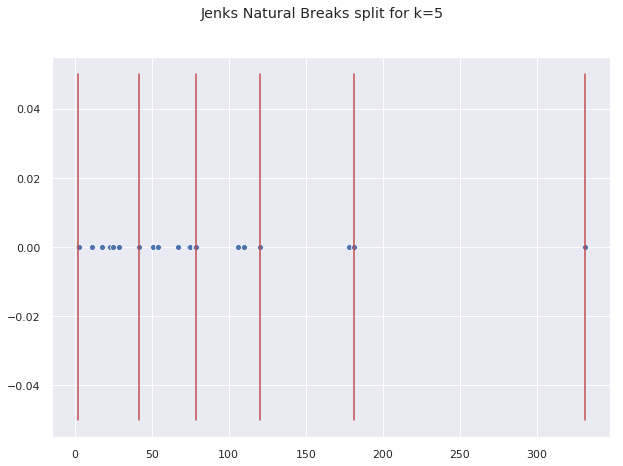

In [50]:
k_splits = min(len(commits), 5)

if len(commits) > k_splits > 3 :

    f, ax = plt.subplots(figsize=(10,7))
    f.suptitle(f"Jenks Natural Breaks split for k={k_splits}")

    sns.scatterplot(x=commit_message_lengths, y=[0] * len(commit_message_lengths), ax=ax)

    jenks_split = jenks_breaks(commit_message_lengths, k_splits)

    for x in jenks_split:
        ax.plot([x] * 100, np.linspace(-0.05, 0.05, 100), 'r')

    plt.show()

else:
    k_splits = 1
    jenks_split = [len(commits[0]), len(commits[-1])]

In [51]:
# discard similar commits
# unique_commits = []
for commit in commits:
    pass

# FIXME -- make commits unique by similarity metric
unique_commits = commits

In [52]:
# split messages by their length into bins
intervals = list(zip(jenks_split[:-1], jenks_split[1:]))

commit_lookup_table = {}

cve_commit_bins = [list() for _ in range(k_splits)]
commit_bins = [list() for _ in range(k_splits)]

for idx, commit in enumerate(unique_commits):
    bin_ = get_interval(intervals, len(set(commit)))
    
    commit_lookup_table[(bin_, len(commit_bins[bin_]))] = commit_data[idx]
    commit_bins[bin_].append(commit)
    
    if contains_cve(commit):
        cve_commit_bins[bin_].append(commit)

In [53]:
interval_means = np.array([
    (low + high) / 2 for low, high in zip(jenks_split[:-1], jenks_split[1:])
])

### TF-IDF

In [54]:
for frame in topic_frames:
    display(frame.loc[:, frame.columns[:10]])

,information,vulnerability,allow,attacker,window,cve,sensitive,server,obtain,user
Gain Information,0.363947,0.301982,0.292438,0.287732,0.262502,0.242108,0.190471,0.172038,0.167724,0.150599


,traversal,directory,dot,file,allow,vulnerability,remote,arbitrary,attacker,parameter
Directory Traversal,0.364082,0.363559,0.342997,0.342738,0.287564,0.285981,0.27307,0.264788,0.256627,0.179408


,cve,vulnerability,remote,attacker,allow,code,execute,arbitrary,memory,php
Code Execution,0.44894,0.309135,0.298918,0.278663,0.272355,0.268416,0.265188,0.264833,0.14125,0.132402


,bypass,allow,attacker,remote,cve,vulnerability,window,restriction,user,access
Bypass something,0.467463,0.375246,0.328848,0.237066,0.220827,0.204732,0.162104,0.147018,0.146155,0.143835


,sql,injection,vulnerability,allow,parameter,remote,execute,arbitrary,command,attacker
Sql Injection,0.572078,0.319342,0.281456,0.27119,0.266546,0.260191,0.249436,0.243448,0.234649,0.225849


,remote,php,inclusion,file,parameter,vulnerability,allow,attacker,arbitrary,code
File Inclusion,0.456638,0.449978,0.271802,0.263805,0.248403,0.236748,0.231337,0.228423,0.227799,0.22426


,csrf,request,forgery,site,allow,cross,attacker,vulnerability,remote,hijack
CSRF,0.412066,0.402199,0.314038,0.260669,0.25665,0.255358,0.248181,0.244162,0.240286,0.192008


,xss,script,vulnerability,site,cross,allow,attacker,user,web,arbitrary
XSS,0.376697,0.355118,0.304765,0.275195,0.263758,0.26306,0.231398,0.216055,0.199876,0.15566


,privilege,gain,allow,window,user,sp,local,vulnerability,attacker,craft
Gain Privileges,0.420438,0.364976,0.333554,0.304677,0.275433,0.241906,0.215721,0.208379,0.125542,0.123584


,cve,service,denial,allow,attacker,memory,craft,corruption,vulnerability,affect
DoS,0.492961,0.325695,0.309284,0.273359,0.253897,0.201663,0.18273,0.179681,0.16816,0.159481


,cve,memory,corruption,code,vulnerability,allow,attacker,affect,arbitrary,service
Memory Corruption,0.774488,0.281281,0.252075,0.145563,0.14521,0.135845,0.12366,0.118978,0.11792,0.116762


,cve,memory,allow,attacker,corruption,service,code,vulnerability,denial,arbitrary
Overflow,0.655166,0.230763,0.213627,0.187314,0.185173,0.171727,0.170641,0.162087,0.159569,0.143373


,http,crlf,split,response,attack,attacker,allow,vulnerability,remote,header
Http Response Splitting,0.427348,0.333249,0.299116,0.291698,0.252273,0.248138,0.239866,0.232974,0.223324,0.199889


In [55]:
commit_score_bins = [None] * k_splits

min_f = 0.05
lookup_table = [
    topic[topic > min_f].dropna(axis=1) for topic in topic_frames
] 

for idx, bin_ in enumerate(commit_bins):
    score_bin = []
    
    msg_lengths = [len(commit) for commit in bin_]
    std_msg_length = np.mean(msg_lengths) + 2 * np.std(msg_lengths)
    
    for commit in bin_:
    
        # capture 95 % commit length within bin
        score_bin.append(get_commit_score(commit, lookup_table, u=std_msg_length))
        
    commit_score_bins[idx] = np.array(score_bin)

commit_score_bins = np.array(commit_score_bins)

In [56]:
# soften 

soft_topic_scores = []
min_bin_size = min([len(bin_) for bin_ in commit_bins])

for basket, basket_mean in zip(commit_score_bins, interval_means):
    basket_scores = np.sum(basket, axis=1) / np.log10(basket_mean)
    basket_scores = np.exp(basket_scores) / np.sum(np.exp(basket_scores))
    
    soft_topic_scores.append(basket_scores)

soft_topic_scores = np.array(soft_topic_scores)

In [57]:
candidate_scores = np.array([
    np.sort(soft_topic_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])
candidate_scores

array([array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333]),
       array([0.38974808, 0.35528036, 0.05194473, 0.05135734, 0.05135734]),
       array([0.53379295, 0.24882547, 0.21738159]),
       array([0.9895769, 0.0104231]), array([0.84786079, 0.15213921])],
      dtype=object)

In [58]:
candidates = np.array([
    np.argsort(soft_topic_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])

candidates

array([array([11, 10,  9,  8,  7]), array([3, 4, 6, 2, 1]),
       array([0, 2, 1]), array([1, 0]), array([1, 0])], dtype=object)

In [59]:
df_candidates = pd.DataFrame()

for bin_number, (arg_bucket, score_bucket) in enumerate(zip(candidates, candidate_scores)):
    for arg, score in zip(arg_bucket, score_bucket):

        flat_idx = sum(len(bin_) for bin_ in commit_bins[:bin_number]) + arg
        
        df_candidates = df_candidates.append(pd.Series({
            'bin': bin_number,
            'message': str(commit_bins[bin_number][arg]),
            'sha': commit_lookup_table[(bin_number, arg)].sha[:8],
            'score': score,
        }, name=flat_idx))
        

#### Results

In [60]:
df_candidates.reset_index().set_index(['bin', 'index'], drop=True).style

##### CVE Commits

In [61]:
commit_score_bins = [None] * k_splits

min_f = 0.05
lookup_table = [
    topic[topic > min_f].dropna(axis=1) for topic in topic_frames
] 

for idx, bin_ in enumerate(cve_commit_bins):
    score_bin = []
    
    msg_lengths = [len(commit) for commit in bin_]
    std_msg_length = np.mean(msg_lengths) + 2 * np.std(msg_lengths)
    
    for commit in bin_:
    
        # capture 95 % commit length within bin
        score_bin.append(get_commit_score(commit, lookup_table, u=std_msg_length))
        
    commit_score_bins[idx] = np.array(score_bin)

commit_score_bins = np.array(commit_score_bins)

/home/macermak/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/macermak/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macermak/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/macermak/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/macermak/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [62]:
# soften 

soft_topic_scores = []
min_bin_size = min([len(bin_) for bin_ in commit_bins])

for basket, basket_mean in zip(commit_score_bins, interval_means):
    if np.any(basket):
        basket_scores = np.sum(basket, axis=1) / np.log10(basket_mean)
        basket_scores = np.exp(basket_scores) / np.sum(np.exp(basket_scores))
    
    else:
        basket_scores = []
        
    soft_topic_scores.append(basket_scores)

soft_topic_scores = np.array(soft_topic_scores)

In [63]:
candidate_scores = np.array([
    np.sort(soft_topic_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])
candidate_scores

array([], shape=(5, 0), dtype=float64)

In [64]:
candidates = np.array([
    np.argsort(soft_topic_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])

candidates

array([], shape=(5, 0), dtype=int64)

In [65]:
df_candidates = pd.DataFrame(columns=['bin', 'message', 'sha', 'score'])

for bin_number, (arg_bucket, score_bucket) in enumerate(zip(candidates, candidate_scores)):
    for arg, score in zip(arg_bucket, score_bucket):

        flat_idx = sum(len(bin_) for bin_ in commit_bins[:bin_number]) + arg
        
        df_candidates = df_candidates.append(pd.Series({
            'bin': bin_number,
            'message': str(cve_commit_bins[bin_number][arg]),
            'sha': commit_lookup_table[(bin_number, arg)].sha[:8],
            'score': score,
        }, name=flat_idx))
        

In [66]:
df_candidates.reset_index().set_index(['bin', 'index'], drop=True).style

,,message,sha,score
bin,index,,,


---

### Spacy

In [67]:
# compute similarity of cve description to commits
cve_description = cve.descriptions.data[0].value

In [68]:
description = nlp(clean_text(cve_description))
description

filesystembytecodecache in jinja>NUMBER< >VERSION< does not properly create temporary directories, which allows local users to gain privileges by pre-creating a temporary directory with a user's uid.  note: this vulnerability exists because of an incomplete fix for CVE.

In [69]:
sim_scores = []

for basket in commit_bins:
    basket_scores = [
        commit.similarity(description)
        for commit in basket
    ]
    sim_scores.append(basket_scores)

sim_scores = np.array(sim_scores)

In [70]:
candidate_scores = np.array([
    np.sort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])
candidate_scores

array([array([0.88626411, 0.8656206 , 0.82061928, 0.81184861, 0.74211225]),
       array([0.931966  , 0.91908256, 0.91624352, 0.90611971, 0.897671  ]),
       array([0.93840748, 0.92555599, 0.91920745]),
       array([0.94010463, 0.88396036]), array([0.95197931, 0.92616367])],
      dtype=object)

In [71]:
candidates = np.array([
    np.argsort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])

candidates

array([array([2, 8, 9, 7, 3]), array([3, 2, 4, 0, 5]), array([2, 1, 0]),
       array([1, 0]), array([1, 0])], dtype=object)

In [72]:
df_candidates = pd.DataFrame()

for bin_number, (arg_bucket, score_bucket) in enumerate(zip(candidates, candidate_scores)):
    for arg, score in zip(arg_bucket, score_bucket):

        flat_idx = sum(len(bins) for bins in commit_bins[:bin_number]) + arg
        
        df_candidates = df_candidates.append(pd.Series({
            'bin': bin_number,
            'message': str(commit_bins[bin_number][arg]),
            'sha': commit_lookup_table[(bin_number, arg)].sha[:8],
            'score': score,
        }, name=flat_idx))
        

#### Results

In [73]:
df_candidates.reset_index().set_index(['bin', 'index'], drop=True).style

In [74]:
#### Same for CVE commits

In [75]:
sim_scores = []

for basket in cve_commit_bins:
    basket_scores = [
        commit.similarity(description)
        for commit in basket
    ]
    sim_scores.append(basket_scores)

sim_scores = np.array(sim_scores)

In [76]:
candidate_scores = np.array([
    np.sort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])
candidate_scores

array([], shape=(5, 0), dtype=float64)

In [77]:
candidates = np.array([
    np.argsort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])

candidates

array([], shape=(5, 0), dtype=int64)

In [78]:
df_candidates = pd.DataFrame(columns=['bin', 'message', 'sha', 'score'])

for bin_number, (arg_bucket, score_bucket) in enumerate(zip(candidates, candidate_scores)):
    for arg, score in zip(arg_bucket, score_bucket):

        flat_idx = sum(len(bins) for bins in commit_bins[:bin_number]) + arg
        
        df_candidates = df_candidates.append(pd.Series({
            'bin': bin_number,
            'message': str(cve_commit_bins[bin_number][arg]),
            'sha': commit_lookup_table[(bin_number, arg)].sha[:8],
            'score': score,
        }, name=flat_idx))
        

In [79]:
df_candidates.reset_index().set_index(['bin', 'index'], drop=True).style

,,message,sha,score
bin,index,,,


---

### Gensim

#### Topic Classification Approach

In [80]:
# model = Doc2Vec.load('data/models/doc2vec_cvedetails_20k/doc2vec.model')
model = Doc2Vec.load('data/models/gensim/doc2vec_cvedetails_20k/doc2vec.model')

In [81]:
sim_scores = []

for basket in commit_bins:
    basket_scores = []
    
    for commit in basket:
        processed_commit = preprocess_string(str(commit))
        
        _, score = model.docvecs.most_similar(
            [model.infer_vector(processed_commit, epochs=50, alpha=0.125)],
            topn=1
        )[0]
        basket_scores.append(score)
        
    sim_scores.append(basket_scores)

sim_scores = np.array(sim_scores)

/home/macermak/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [82]:
candidate_scores = np.array([
    np.sort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])
candidate_scores

array([array([0.22580123, 0.22130626, 0.21456458, 0.21292654, 0.21211305]),
       array([0.25721061, 0.23509994, 0.2226707 , 0.21853039, 0.16993049]),
       array([0.19038542, 0.12558784, 0.05869767]),
       array([0.27520484, 0.17115498]), array([0.19489262, 0.14545986])],
      dtype=object)

In [83]:
candidates = np.array([
    np.argsort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])

candidates

array([array([11,  4,  5,  6,  1]), array([4, 3, 1, 6, 2]),
       array([1, 2, 0]), array([1, 0]), array([1, 0])], dtype=object)

In [84]:
df_candidates = pd.DataFrame(columns=['bin', 'message', 'sha', 'score'])

for bin_number, (arg_bucket, score_bucket) in enumerate(zip(candidates, candidate_scores)):
    for arg, score in zip(arg_bucket, score_bucket):

        flat_idx = sum(len(bins) for bins in commit_bins[:bin_number]) + arg
        
        df_candidates = df_candidates.append(pd.Series({
            'bin': bin_number,
            'message': str(commit_bins[bin_number][arg]),
            'sha': commit_lookup_table[(bin_number, arg)].sha[:8],
            'score': score,
        }, name=flat_idx))
        

##### Results

In [85]:
df_candidates.reset_index().set_index(['bin', 'index'], drop=True).style

#### Description similarity

In [86]:
# model = Doc2Vec.load('data/models/doc2vec_cvedetails_20k/doc2vec.model')
model = Doc2Vec.load('data/models/gensim/doc2vec_cvedetails_20k/doc2vec.model')

In [87]:
description = preprocess_string(clean_text(cve_description))
description_vector = model.infer_vector(description, epochs=50, alpha=0.125)

In [88]:
sim_scores = []

for basket in commit_bins:
    basket_scores = []
    
    for commit in basket:
        processed_commit = preprocess_string(str(commit))
        
        score, = model.wv.cosine_similarities(
            model.infer_vector(processed_commit, epochs=50, alpha=0.001),
            [description_vector]
        )
        basket_scores.append(score)
        
    sim_scores.append(basket_scores)

sim_scores = np.array(sim_scores)

In [89]:
candidate_scores = np.array([
    np.sort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])
candidate_scores

array([array([0.46584696, 0.42075565, 0.34434262, 0.3393493 , 0.3390711 ],
      dtype=float32),
       array([0.38195646, 0.37339044, 0.3315656 , 0.293278  , 0.23723407],
      dtype=float32),
       array([0.4224901 , 0.35324714, 0.14853337], dtype=float32),
       array([0.40970474, 0.34336466], dtype=float32),
       array([0.3079575 , 0.26013935], dtype=float32)], dtype=object)

In [90]:
candidates = np.array([
    np.argsort(sim_scores[i], axis=0)[::-1][:5]
    for i in range(k_splits)
])

candidates

array([array([ 3,  9,  5, 11,  6]), array([2, 6, 0, 4, 3]),
       array([2, 1, 0]), array([0, 1]), array([0, 1])], dtype=object)

In [91]:
df_candidates = pd.DataFrame(columns=['bin', 'message', 'sha', 'score'])

for bin_number, (arg_bucket, score_bucket) in enumerate(zip(candidates, candidate_scores)):
    for arg, score in zip(arg_bucket, score_bucket):

        flat_idx = sum(len(bins) for bins in commit_bins[:bin_number]) + arg
        
        df_candidates = df_candidates.append(pd.Series({
            'bin': bin_number,
            'message': str(commit_bins[bin_number][arg]),
            'sha': commit_lookup_table[(bin_number, arg)].sha[:8],
            'score': score,
        }, name=flat_idx))
        

##### Results

In [92]:
df_candidates.reset_index().set_index(['bin', 'index'], drop=True).style